In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import cv2
import os, sys, glob
from tqdm import tqdm
from model import model1, model2
sys.path.insert(0,"/home/msmith/misc/py/")
from performance import Performance
from hStackBatch import hStackBatch
from loadData import loadData
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline
from pylab import rcParams
rcParams["figure.figsize"] = 20, 10

def displayBatch(X):
    try:
        #X,Y = XY
        #names = train.decodeToName(Y)
        X *= 255.0
        bs = X.shape[0]
        X = X.astype(np.uint8)[:,:,:,::-1]
        fig = plt.figure(figsize=(40,20))
        idx = 0
        for i in range(1,bs+1):
            ax = fig.add_subplot(1,bs+1,i)
            ax.set_xticklabels([])
            ax.set_yticklabels([])
            plt.imshow(X[idx])
            #ax.set_title(names[idx])
            idx +=1
        plt.show()
    except IndexError:
        print("OOB")

In [ ]:
if __name__ == "__main__":
    batchSize  = 6
    batchCapacity = 40
    nThreads = 32

    ## HyperParameter defaults
    h, w, c = 200, 200, 3
    nClasses = 447
    inDims = [None,h,w,c]
    nFeatsInit = 64
    nFeatsInc = 32
   
    load = 1
    display = 1
    disFreq = 400
    lr = 1e-5
    nEpochs = 10

    # Decode csv
    csvPathTr = "/home/msmith/kaggle/whale/trainCV.csv"
    csvPathTe = "/home/msmith/kaggle/whale/testCV.csv"
    trObs = pd.read_csv(csvPathTr).shape[0]
    def nodes(trainOrTest):
        assert trainOrTest in ["train","test"], "Please specify either 'train' or 'test."
        if trainOrTest == "train":
            csvPath = csvPathTr
            shuffle = True
        else:
            csvPath = csvPathTe
            shuffle = False
        x, y, yPaths = loadData(csvPath,shape=[h,w,c],batchSize=batchSize,batchCapacity=batchCapacity,nThreads=nThreads)
        # Define placeholders and model
        yPred = model1(x,inDims=inDims,nClasses=nClasses,nFeatsInit=nFeatsInit,nFeatsInc=nFeatsInc) # model
        ce = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(yPred,y))
        
        correct = tf.equal(tf.argmax(yPred,1), tf.argmax(y,1))
        accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
        trainStep = None
        if trainOrTest == "train":
            learningRate = tf.placeholder(tf.float32)
            trainStep = tf.train.AdamOptimizer(learningRate).minimize(ce)
            return x, y, yPaths, yPred, ce, correct, accuracy, trainStep, learningRate
        else:
            return x, y, yPaths, yPred, ce, correct, accuracy
    
    modelName = "models/model1.tf"
    

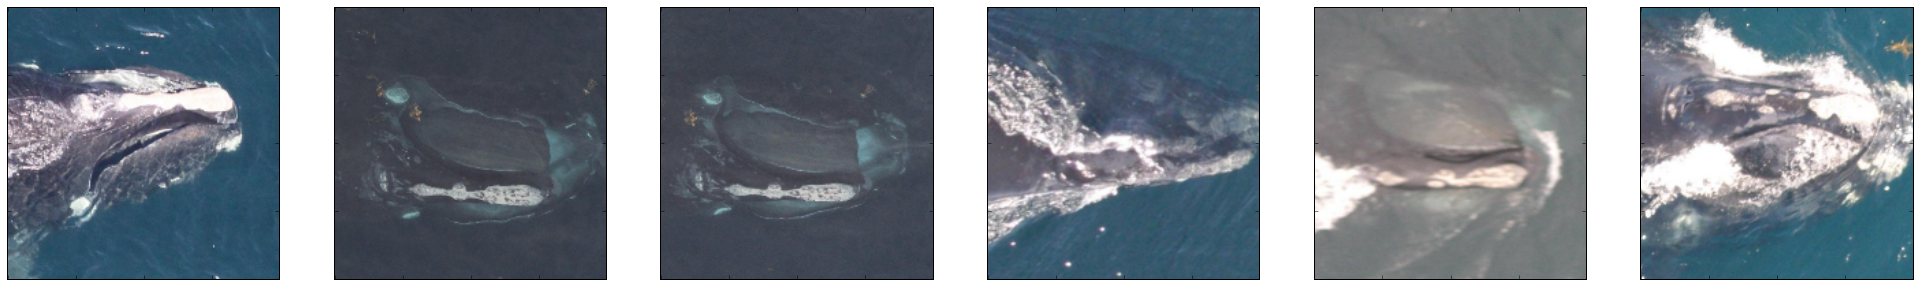

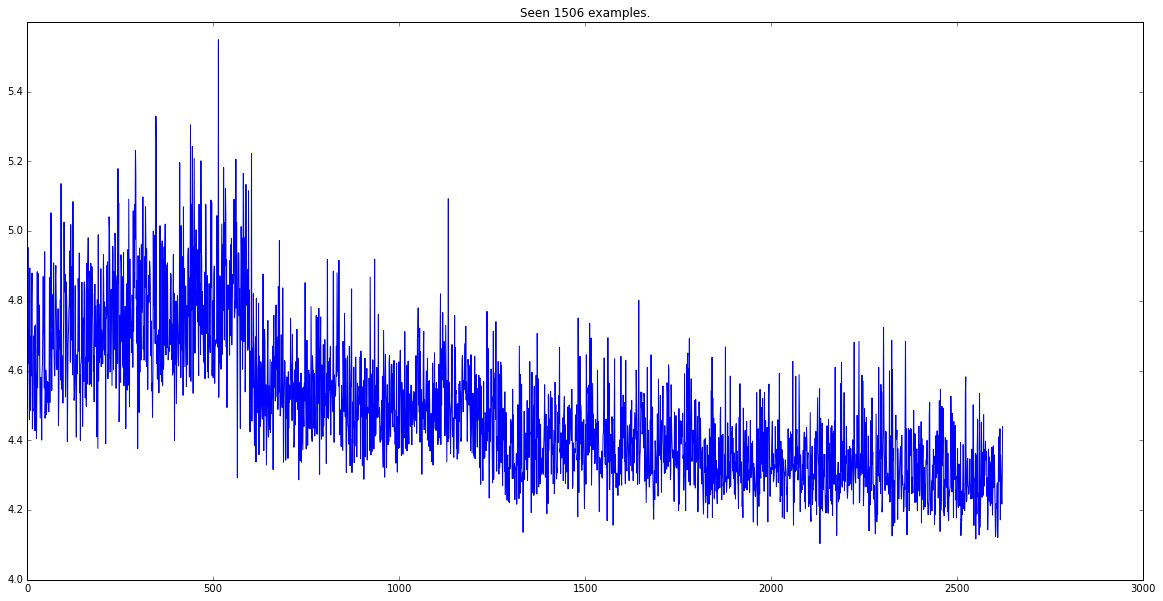

 58%|█████▊    | 345/593 [00:33<00:21, 11.40it/s]

In [ ]:
if __name__ == "__main__":
    nIterationsTr = trObs/batchSize
    trLosses = []
    
    for epoch in xrange(nEpochs):
        if epoch > 0:
            tf.reset_default_graph()
        x, y, yPaths, yPred, ce, correct, accuracy, trainStep, learningRate = nodes("train")
        saver = tf.train.Saver()
        with tf.Session() as sess:
            if load == 1:
                
                saver.restore(sess,modelName)
            else:    
                init = tf.initialize_all_variables()
                sess.run(init)
            coord = tf.train.Coordinator()
            threads = tf.train.start_queue_runners(sess=sess,coord=coord)
            count = 0
              
            for i in tqdm(xrange(nIterationsTr)):
                _, loss_, x_, y_,yPred_, yPaths_ = sess.run([trainStep, ce, x, y, yPred, yPaths],feed_dict={learningRate:lr})
                trLosses.append(loss_)
                count += x_.shape[0]
                if i % 250 == 0:
                    clear_output()
                    displayBatch(x_)
                    plt.title("Seen {0} examples.".format(count))
                    trLossesT = np.array(trLosses)
                    plt.plot(trLossesT)
                    plt.show()

                if epoch % 2 == 0 and epoch >0:
                    lr /= 1.5
                    print("learning rate now = {0}".format(lr))
            saver.save(sess,modelName)
            load = 1
            sess.close()